In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Read csv and add header
data = pd.read_csv('RadarChuvaJan2021-6d.csv', 
        header=0, names=['day', 'DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV', 'Tp_est'])

In [ ]:
# Create a copy DF and ignore all rows where Tp_est is 0
pluvi_df = data.loc[data['Tp_est'] != 0]

# Fill Tp_est NaN values with 0 and remove all of them
pluvi_df['Tp_est'].fillna(0, inplace=True)
pluvi_df = pluvi_df.loc[pluvi_df['Tp_est'] != 0]

### Functions

In [4]:
# calculate the instances per day and plot 
def instances_per_day(df):
    day = []
    day_instances = []

    for i in range(1, 32):
        day.append(i)
        day_instances.append(len(df['day'].loc[df['day'] < f'2021-01-{i}']))

    day_instances_df = pd.DataFrame({'day': day, 'instances': day_instances})

    # line plot
    sns.set_theme()
    sns.lineplot(data=day_instances_df, x='day', y='instances').set_title('Number of instances per day')

    return day_instances_df

In [5]:
# train/test split and normalize data
def data_split_normalized(df: pd.DataFrame, day: int):
    # data split: train takes all instances before 2021-01-{day} and test takes all instances after 2021-01-{day}
    X_train = df.loc[df['day'] < f"2021-01-{day}"].drop(['day', 'Tp_est'], axis=1)
    y_train = df.loc[df['day'] < f"2021-01-{day}"]['Tp_est']
    X_test = df.loc[df['day'] > f"2021-01-{day}"].drop(['day', 'Tp_est'], axis=1)
    y_test = df.loc[df['day'] > f"2021-01-{day}"]['Tp_est']

    # normalize data
    scaler = preprocessing.MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    return X_train, y_train, X_test, y_test


# train model (regressor)
def train_model(X_train, y_train):
    model = DecisionTreeRegressor(max_depth=5)
    # model = SVR(C=1.0)
    model.fit(X_train, y_train)

    return model


# show the metrics for the predictions
def show_metrics(y_test, predictions):
    print('mean squared error: ', mean_squared_error(y_test, predictions))
    print('mean absolute error: ', mean_absolute_error(y_test, predictions))


# show the dispersion plot for the predictions
def show_dispersion_plot(y_test, predictions):
    data = pd.DataFrame({'y_test': y_test, 'predictions': predictions})
    sns.set_theme()
    sns.scatterplot(data=data, x="y_test", y="predictions").set_title('Dispersion Plot')


# function to create a model for a given day
def create_model(df: pd.DataFrame, day: int):
    X_train, y_train, X_test, y_test = data_split_normalized(df, day)
    model = train_model(X_train, y_train)
    predictions = model.predict(X_test)
    show_metrics(y_test, predictions)
    show_dispersion_plot(y_test, predictions)


### Dataset structure
* total rows: **107,135**
* rows where Tp_est is not *zero*: **13,998** -> data we will use
* rows excluded: **93,137**

In [6]:
pluvi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12525 entries, 9 to 107110
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     12525 non-null  object 
 1   DBZH    5197 non-null   float64
 2   DBZV    4623 non-null   float64
 3   KDP     2266 non-null   float64
 4   ZDR     12525 non-null  float64
 5   RHOHV   12525 non-null  float64
 6   Tp_est  12525 non-null  float64
dtypes: float64(6), object(1)
memory usage: 782.8+ KB


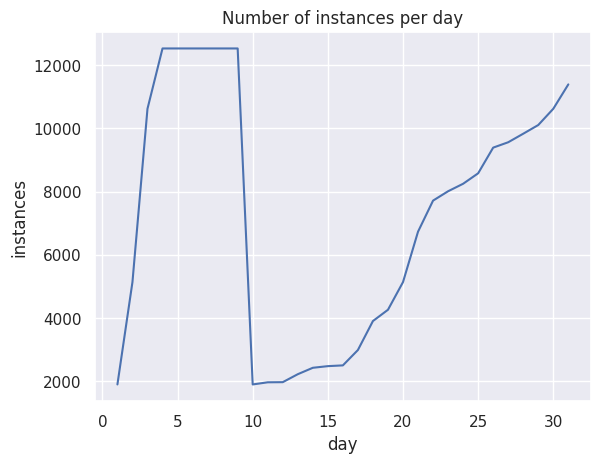

In [7]:
# plot the instances per day
day_instances_df = instances_per_day(pluvi_df)

### Drop NaN
* total rows after removing all NaN: **1664**

In [8]:
pluvi_df_not_nan = pluvi_df.dropna()
pluvi_df_not_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1664 entries, 260 to 107081
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     1664 non-null   object 
 1   DBZH    1664 non-null   float64
 2   DBZV    1664 non-null   float64
 3   KDP     1664 non-null   float64
 4   ZDR     1664 non-null   float64
 5   RHOHV   1664 non-null   float64
 6   Tp_est  1664 non-null   float64
dtypes: float64(6), object(1)
memory usage: 104.0+ KB


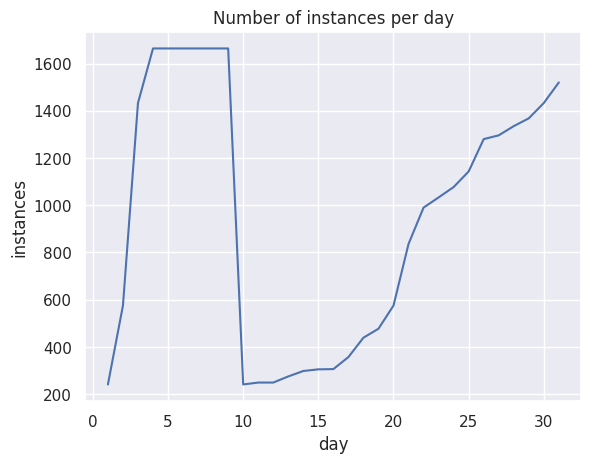

In [9]:
# instances per day of the dataset with NaN values (same line shape)
day_instances_df = instances_per_day(pluvi_df_not_nan)

mean squared error:  4.118490254949037
mean absolute error:  1.0077576058155309


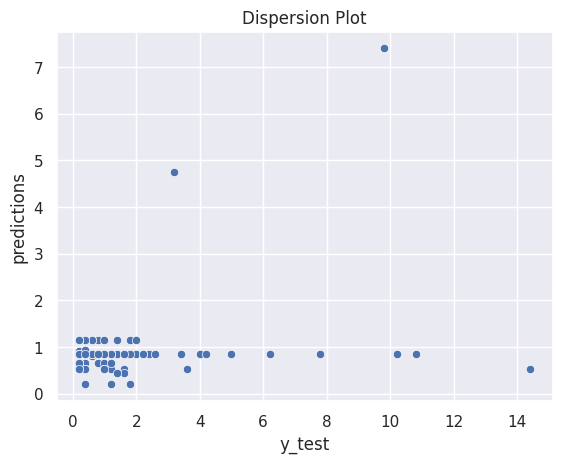

In [10]:
create_model(df=pluvi_df_not_nan, day=31)

### Replace NaN with Mean, Median and Zero

#### Fill NaN with Mean

/tmp/ipykernel_25116/1636300467.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pluvi_df_mean = pluvi_df.fillna(pluvi_df.mean())


mean squared error:  3.3799821514115864
mean absolute error:  0.9478652661914089


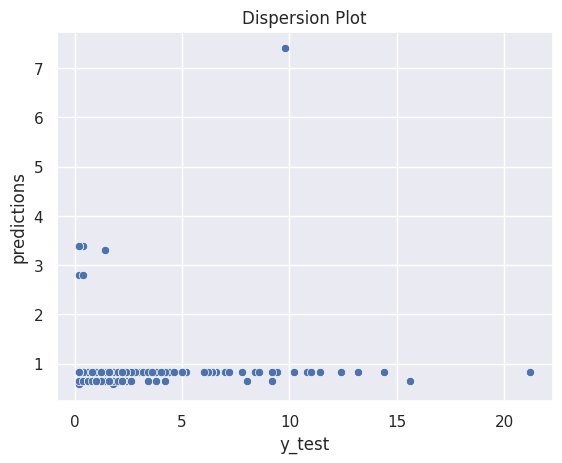

In [11]:
pluvi_df_mean = pluvi_df.fillna(pluvi_df.mean())
create_model(pluvi_df_mean, 31)

#### Fill NaN with Zero

mean squared error:  3.345775407806409
mean absolute error:  0.9777626283545493


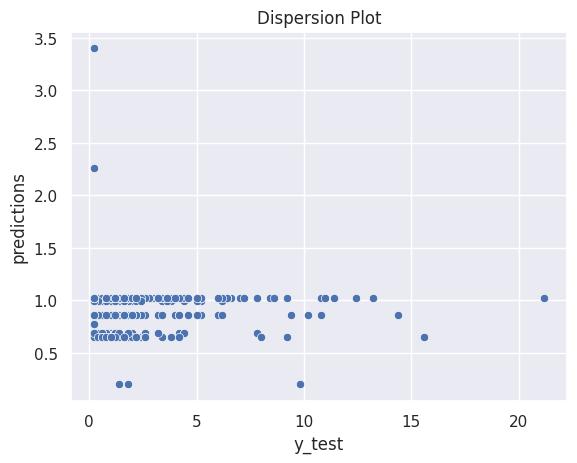

In [12]:
pluvi_df_mean = pluvi_df.fillna(0)
create_model(pluvi_df_mean, 31)

#### Fill NaN with KNN Value Imputer

In [13]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(
    pluvi_df[['DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV']]), columns = ['DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV'])

mean squared error:  3.5932128701038915
mean absolute error:  0.9800858875127498


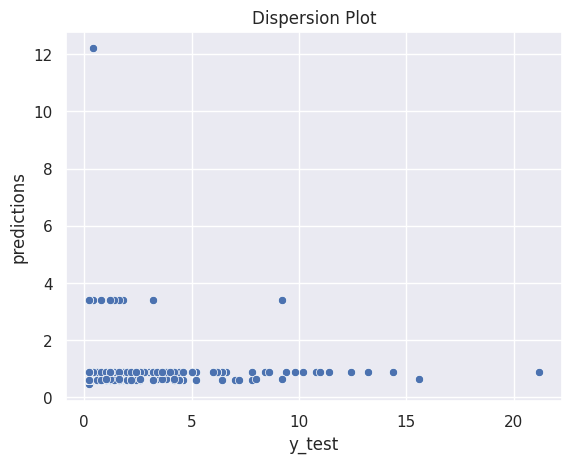

In [14]:
knn_df = df.copy()
knn_df['Tp_est'] = pluvi_df['Tp_est'].values
knn_df['day'] = pluvi_df['day'].values
create_model(knn_df, 31)